# Synthetic Music Theory

In the last episode, we looked at the modes derived from the major scale.
We looked at pairwise distances between these modes and constructed a geometric representation based on those distances.
Amazingly (maybe?) this representation was a straight line where the modes were arranged according the circle of fifths.

Is this a lucky coincidence?
Or is this a common feature?
What does common even mean?

Here we consider some artificial or *synthetic* musical systems based on modes other than the major scale and also abstracting some other features of our *normal* musical system.

By examining these other systems, we can hope to discover which features are common and which are special and how these features are related.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Image, display
import seaborn as sns
import copy

# Mini-ionian

Let's think about an abstract scale that has only three (distinct) notes instead of seven.
We define it as a sequence of half steps and whole steps.

mini_ionian = 'WWH'

If these were played starting on C, it would go C, D, E, F.

Of course if we played this on a piano, it would not create a cycle in the usual sense - we end up on F and not at another C.

Let's not worry about this for now, but focus instead on the sequences of symbols "H" and "W".

From this parent mode, we can derive the other related modes through permutation.

These related modes are defined by the sequences WHW, HWW.
We can call these "mini-dorian" and "mini-phrygian".

------

Note:
Here, "H" and "W" are just symbols and don't necessarily correspond to traditional half-step and whole-step.
If "W" must be worth twice as much as "H", then this scale has 5 half-steps (C, C&sharp;, D, D&sharp;, E, F=C).
To move up one octave in 5 half-steps, each H must represent multiplication of the frequency by the fifth root of 2 (more or less).
This would yield a "D", and "E" that are not standard Western pitches.
In fact, this "D" would be close to a traditional "F" and this "E" would be close to a traditional "B&flat;".

While this sounds interesting, it's not the point of this exploration.

# Compute by hand

This system is really simple, so we can compute everything by hand.
Let's do that here to make sure the steps are clear.
Then we can see if our previous algorithm functions as we expect.

Pattern:
- mini-ionian = WWH
- mini-dorian = WHW
- mini-phrygian = HWW

Cumulative:
- mini-ionian = 0, 2, 4, 5
- mini-dorian = 0, 2, 3, 5
- mini-phrygian = 0, 1, 3, 5

Manhattan distances:
- mini-ionian to mini-dorian = 1
- mini-dorian to mini-phrygian = 1
- mini-ionian to mini-phrygian = 2

>Notice that we can represent these distances using a straight line.

mini-ionian --- mini-dorian --- mini-phrygian

>We also see that the "left-most" mode corresponds to the start of the largest block of Ws.

# Questions:

- Will we always find the geometry of a straight line?
- How are the positions of the modes related to things like blocks of Ws?
- What if we restrict our attention to those modes that yield 12 half steps?
- What if we include other interval types like three-half-steps, four-half-steps,..?

# Generate lots of other synthetic systems.

Let's organize this by the total "distance" covered by the steps in our scale,

$$T = 1 * number(H) + 2 * number(W)$$.

(Our standard system has $T = 1 * 2 + 2 * 5 = 12$.)

- First, how many unique sets of half-steps and whole-steps yield a desired total $T$?

For example, given a target of $T = 12$, we find the following sets: 
{WWWWWW}, {WWWWWHH}, {WWWWHHHH}, {WWWHHHHHH}, {WWHHHHHHHH}, {WHHHHHHHHHHHH}, or {HHHHHHHHHHHH}.

- Second, given one of these sets, how many unique ways are there to arrange these symbols? 

We'll have to think a little bit extra about this one..

## The first task is straightforward.

In [2]:
def step_tuples_from_total(T):
    """Given the total number of half steps, `T`, return a generator for all possible combinations of numbers of 
    half and whole steps that make up this total."""
    
    Nhalf = T
    Nwhole = 0
    
    while Nhalf >= 0:
        yield (Nhalf, Nwhole)
        
        Nhalf -= 2
        Nwhole += 1    
        
def step_tuple_to_HW_string(tup):
    """Given a tuple (num_half, num_whole), return a string 'HHHHWWWW' where the number of Hs and Ws corresponds 
    to the given num_half and num_whole resp."""
    return ''.join(tup[0] * ['H'] + tup[1] * ['W'])

In [3]:
# For example,
T = 12

sds = step_tuples_from_total(T)

for sd in sds:
    print(sd, step_tuple_to_HW_string(sd))

(12, 0) HHHHHHHHHHHH
(10, 1) HHHHHHHHHHW
(8, 2) HHHHHHHHWW
(6, 3) HHHHHHWWW
(4, 4) HHHHWWWW
(2, 5) HHWWWWW
(0, 6) WWWWWW


## Given a step distribution, how many arrangements are there?

For example, (2, 5) corresponds to the set of steps HHWWWWW.
There are exactly 6 unique permutations: HHWWWWW, HWHWWWW, HWWHWWW, HWWWHWW, HWWWWHW, and HWWWWWH.

### This is actually too many!

Remember, our analysis: start with parent mode, generate related modes through cyclic permutation, compute pairwise distances, produce geometric representation.

There is no need to perform this analysis for, say, both ionian *and* dorian.
That's because ionian and dorian are related by cyclic permutation and will fall within the same analysis.

>We want to choose only only one representative from each class of modes that is related by cyclic permutation.

In the above example, the latter three can be generated from the first three.
- HWWWHWW can be derived from HWWHWWW
- HWWWWHW can be derived from HWHWWWW
- HWWWWWH can be derived from HHWWWWW

How, then, do we go about generating the desired patterns?

This is actually a pretty interesting problem, and not entirely trivial - in fact it goes by the name of "necklace theory".

You can read more about the theory:
<https://en.wikipedia.org/wiki/Necklace_(combinatorics)>


A few references I should go through.
Looks like Forte number / normal form etc is very much related to the necklace problem.
I don't see anything in these references that looks like the distance metric stuff.
- <https://en.wikipedia.org/wiki/Forte_number>
- <https://en.wikipedia.org/wiki/List_of_pitch-class_sets>
- <http://www.jaytomlin.com/music/settheory/help.html>

In [4]:
import itertools
        
def has_cyclic_representative(this_perm, perms):
    """Given a particular permutation `this_perm` of some fixed elements, and a list of permutations `perms`, 
    determine if this_perm is cyclically related to any element of perms."""
    
    L = len(this_perm)
    this_perm_class = set(this_perm[i:] + this_perm[:i] for i in range(L))
    
    for other_perm in perms:
        if other_perm in this_perm_class:
            return True

    return False
    
def get_necklaces(x, fast=True):
    """Given a list x, return a list of all different 'necklaces' that correspond to this list.
    
    Necklaces are defined as all arrangements of the objects in the list subject to two symmetries: object identity 
    and cyclic permutation.
    
    For example, if the input list had one 'A' and two 'B's, then there would be only one list ['B', 'A', 'B'] in the 
    output. That is, the two 'B's are indistinguishable.
    
    Also, the output could contain ['B', 'A', 'B'], but then would not contain ['A', 'B', 'B'] because these two lists
    are related by cyclic permutation.
    
    We're going to do this the naive way for now.
    First, create all configurations with itertools and then check for equivalence to a previous element.
    """
    
    if fast is True:
        unique_perms = unique_permutations(x) # Instead use this efficient construction
    else:
        # Naive method
        # Use itertools to create all permutations and use `set` to get the unique ones.
        unique_perms = set(itertools.permutations(x, len(x))) # THIS IS TOO SLOW
    
    # Finally, pick out one from each equivalence class (under cyclic permutation).
    necklace_perms = set()
    for perm in unique_perms:
        perm = ''.join(perm)
        if not has_cyclic_representative(perm, necklace_perms):
            necklace_perms.add(perm)
            
    return necklace_perms

def unique_permutations(seq):
    """
    Yield only unique permutations of seq in an efficient way.

    A python implementation of Knuth's "Algorithm L", also known from the 
    std::next_permutation function of C++, and as the permutation algorithm 
    of Narayana Pandita.
    
    This was posted on stackoverflow by Lauritz V. Thaulow
    https://stackoverflow.com/questions/12836385/how-can-i-interleave-or-create-unique-permutations-of-two-strings-without-recur/12837695#12837695
    """

    # Precalculate the indices we'll be iterating over for speed
    i_indices = range(len(seq) - 1, -1, -1)
    k_indices = i_indices[1:]

    # The algorithm specifies to start with a sorted version
    seq = sorted(seq)

    while True:
        yield seq

        # Working backwards from the last-but-one index,           k
        # we find the index of the first decrease in value.  0 0 1 0 1 1 1 0
        for k in k_indices:
            if seq[k] < seq[k + 1]:
                break
        else:
            # Introducing the slightly unknown python for-else syntax:
            # else is executed only if the break statement was never reached.
            # If this is the case, seq is weakly decreasing, and we're done.
            return

        # Get item from sequence only once, for speed
        k_val = seq[k]

        # Working backwards starting with the last item,           k     i
        # find the first one greater than the one at k       0 0 1 0 1 1 1 0
        for i in i_indices:
            if k_val < seq[i]:
                break

        # Swap them in the most efficient way
        (seq[k], seq[i]) = (seq[i], seq[k])                #       k     i
                                                           # 0 0 1 1 1 1 0 0

        # Reverse the part after but not                           k
        # including k, also efficiently.                     0 0 1 1 0 0 1 1
        seq[k + 1:] = seq[-1:k:-1]

In [5]:
x = ['H', 'H', 'W', 'W', 'W', 'W', 'W']

print(get_necklaces(x))

{'HWHWWWW', 'HHWWWWW', 'HWWHWWW'}


## The algorithm is important

It is interesting to see how even for this fairly simple task we can run into computation time issues.
Without going deep into the differences, let's just observe the difference between a "naive" algorithm and a "fast" algorithm.

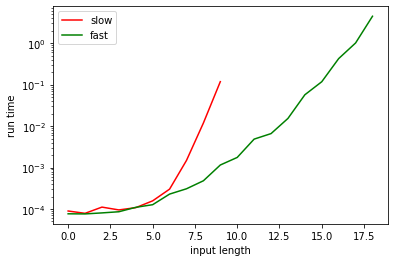

In [6]:
import time

num_repeats = 5

slow_times = []
for ind in range(10):
    t0 = time.perf_counter()
    for rind in range(num_repeats):
        get_necklaces(np.random.choice(['H', 'W'], size=ind, replace=True), fast=False)
    dt = (time.perf_counter() - t0) / num_repeats
    slow_times.append(dt)
    
fast_times = []
for ind in range(19):
    t0 = time.perf_counter()
    for rind in range(num_repeats):
        get_necklaces(np.random.choice(['H', 'W'], size=ind, replace=True), fast=True)
    dt = (time.perf_counter() - t0) / num_repeats
    fast_times.append(dt)
    
fig = plt.figure()
plt.semilogy(slow_times, 'r', label='slow')
plt.semilogy(fast_times, 'g', label='fast')
plt.xlabel('input length')
plt.ylabel('run time')
plt.legend()
plt.show()

We can see that even for just 12 symbols, the slow algorithm will take a minute or two.
The fast algorithm finishes in about 1/100th of a second and we can go up to 18 in just a few seconds.

## That was kind of a lot - so let's review.

The question is: What are all of the patterns of half-steps and whole-steps can we take?

Remember: the idea of half-step and whole-step are abstracted so they don't necessarily correspond to the notes on the piano.

There are many different ways.

First we decide a total distance $T = 1 * num(half) + 2 * num(whole)$.

Then we choose a set of half-steps and whole-steps.

Then we choose an arrangement of these steps.
If this arrangement is related to a previous arrangement by cyclic permutation, we don't bother with it again.

In [7]:
sds = step_tuples_from_total(12)

for sd in sds:
    print(sd, step_tuple_to_HW_string(sd))

(12, 0) HHHHHHHHHHHH
(10, 1) HHHHHHHHHHW
(8, 2) HHHHHHHHWW
(6, 3) HHHHHHWWW
(4, 4) HHHHWWWW
(2, 5) HHWWWWW
(0, 6) WWWWWW


Then, we can take any one of these and find all of the permutations that are "modally relevant" - that is, are not cyclically related.

In [8]:
sds = step_tuples_from_total(12)
base_modes = []
for sd in sds:
    #print(step_tuple_to_HW_string(sd))
    necklaces = get_necklaces(step_tuple_to_HW_string(sd))
    #print(necklaces)
    base_modes += [n for n in necklaces]
    #print(len(necklaces))
print(base_modes)
print(len(base_modes))

['HHHHHHHHHHHH', 'HHHHHHHHHHW', 'HHHHHHHWHW', 'HHHHWHHHHW', 'HHHHHHHHWW', 'HHHHHHWHHW', 'HHHHHWHHHW', 'HHHHWHWHW', 'HHHWHHWHW', 'HHHHWHHWW', 'HHHWHWHHW', 'HHWHHWHHW', 'HHHHHWHWW', 'HHHHHHWWW', 'HHHHWWHHW', 'HHHHHWWHW', 'HHHWHHHWW', 'HHHHWWWW', 'HHHWHWWW', 'HHWWHWHW', 'HHWWHHWW', 'HHWHWWHW', 'HHWHHWWW', 'HWHWHWHW', 'HHHWWWHW', 'HHHWWHWW', 'HHWHWHWW', 'HWHWWWW', 'HHWWWWW', 'HWWHWWW', 'WWWWWW']
31


This says that within a scale from C up 12 half-steps to C where we travel by half-steps and whole-steps, there are a total of 31 "modal worlds".

Our analysis above of the ionian-based modal world found that that world could be geometrized as a straight line.

How many of these 31 worlds are also linear?
If they are not linear, what are they?

What about other common base modes like melodic minor?

In [9]:
# base_pattern = 'HHHHWWWW'

# def cycle_pattern(pattern, shift):
#     return pattern[shift:] + pattern[:shift]

# mode_names = ['mode {}'.format(i) for i in range(len(base_pattern))]

# mode_df = pd.DataFrame(mode_names, columns=['name'])

# mode_df['pattern'] = base_pattern

# mode_df['pattern'] = mode_df.apply(lambda row: cycle_pattern(row.pattern, row.name), axis=1)

# mode_df

In [10]:
def pattern_to_int_pattern(pattern):
    d = {'H':1, 'W':2}
    # First map to integers
    return  list(map(lambda char: d[char], pattern))

def int_pattern_to_cumulative(int_pattern):
    # This version prepends a zero.
    # return np.append([0], np.cumsum(int_pattern))
    # This version has no initial zero.
    return np.cumsum(int_pattern)

# mode_df['int pattern'] = mode_df['pattern'].apply(pattern_to_int_pattern)
# mode_df['cumul pattern'] = mode_df['int pattern'].apply(int_pattern_to_cumulative)

# mode_df

In [11]:
from scipy.spatial.distance import squareform, pdist

# cpats = np.stack(mode_df['cumul pattern'].values)

# pairwise_df = pd.DataFrame(squareform(pdist(cpats, metric='cityblock')), columns=mode_df['name'], 
#                            index=mode_df['name'])
# pairwise_df

In [12]:
# plt.figure(figsize=(6, 6))
# sns.heatmap(pairwise_df, cmap='coolwarm', linewidth=1);
# plt.axis('equal')

In [13]:
def base_pattern_to_modemode_map(pattern, ax):

    mode_names = ['mode {}'.format(i) for i in range(len(pattern))]
    mode_df = pd.DataFrame(mode_names, columns=['name'])
    mode_df['pattern'] = pattern
    mode_df['pattern'] = mode_df.apply(lambda row: cycle_pattern(row.pattern, row.name), axis=1)

    mode_df['int pattern'] = mode_df['pattern'].apply(pattern_to_int_pattern)
    mode_df['cumul pattern'] = mode_df['int pattern'].apply(int_pattern_to_cumulative)
    
#     print(mode_df)
    
    cpats = np.stack(mode_df['cumul pattern'].values)

    pairwise_df = pd.DataFrame(squareform(pdist(cpats, metric='cityblock')), columns=mode_df['name'], 
                               index=mode_df['name'])
    
    sns.heatmap(pairwise_df, cmap='coolwarm', linewidth=1, ax=ax, cbar=False,  
                annot=pairwise_df.values.astype(int), fmt='');
    
    ax.set_title(pattern)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.axis('equal')

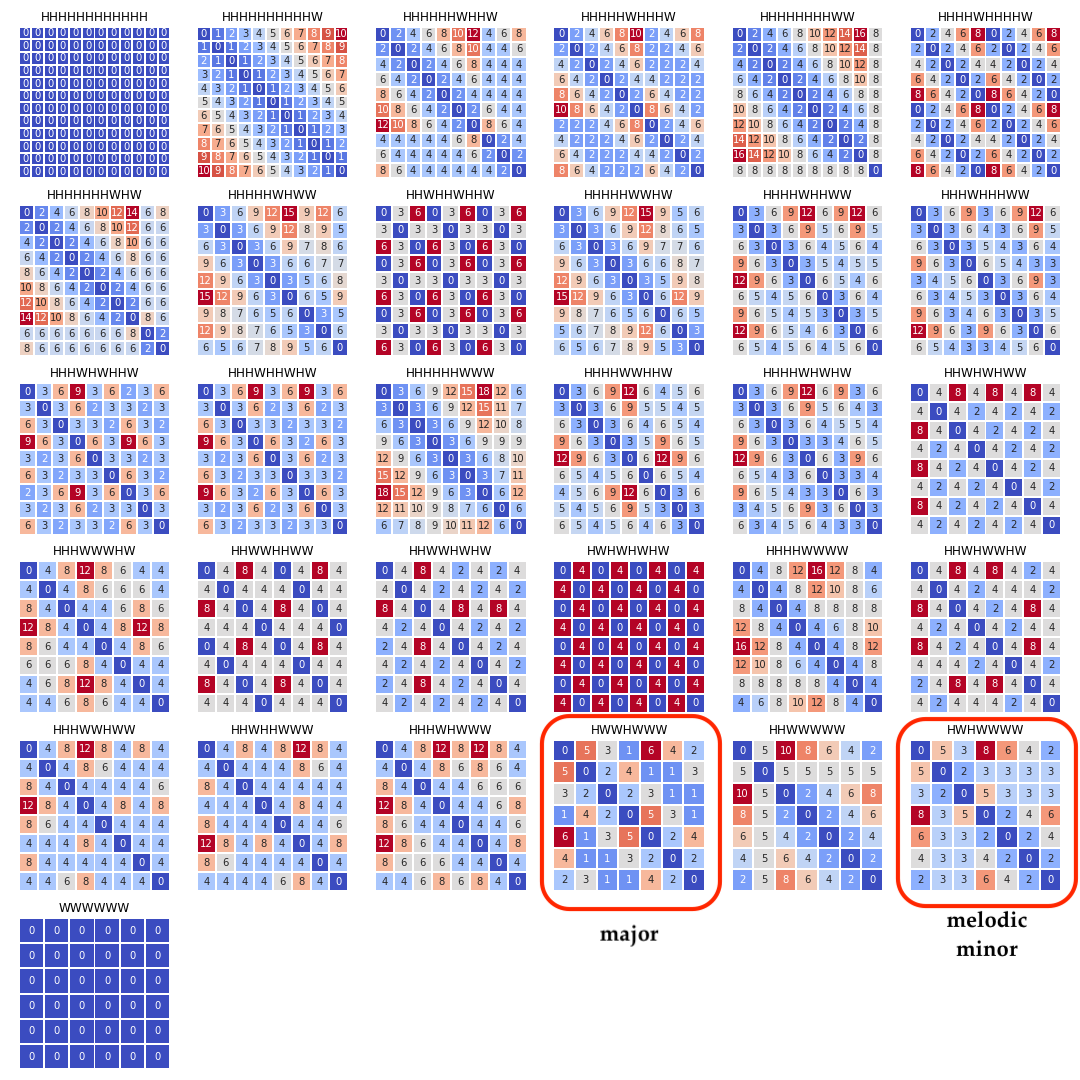

In [14]:
# fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))

# axs = axs.flatten()

# sds = step_dist_from_total(12)

# ind = 0
# for sd in sds:
#     necklaces = get_necklaces(step_tuple_to_HW_string(sd), fast=True)
#     for pattern in necklaces:
#         base_pattern_to_modemode_map(pattern, axs[ind])
#         ind += 1
        
# while ind < len(axs):
#     axs[ind].set_visible(False)
#     ind += 1
    
# plt.tight_layout()

# fig.savefig('12_half_step_mode_universe.png')
# plt.close('all')

result_image = Image("./12_half_step_mode_universe_annotated.png")

display(result_image)

In [15]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA

In [16]:
def base_pattern_to_MDS_manifold(pattern, ax):
    seed = np.random.RandomState(seed=234)

    mode_names = ['mode {}'.format(i) for i in range(len(pattern))]
    mode_df = pd.DataFrame(mode_names, columns=['name'])
    mode_df['pattern'] = pattern
    mode_df['pattern'] = mode_df.apply(lambda row: cycle_pattern(row.pattern, row.name), axis=1)

    mode_df['int pattern'] = mode_df['pattern'].apply(pattern_to_int_pattern)
    mode_df['cumul pattern'] = mode_df['int pattern'].apply(int_pattern_to_cumulative)
    
    #print(mode_df)
    
    cpats = np.stack(mode_df['cumul pattern'].values)

    pairwise_df = pd.DataFrame(squareform(pdist(cpats, metric='cityblock')), columns=mode_df['name'], 
                               index=mode_df['name'])
    
    symmetric_noise = np.random.uniform(low=0, high=0.001, size=pairwise_df.values.shape)
    symmetric_noise += symmetric_noise.T
    pairwise_df += symmetric_noise
    
    mds = MDS(n_components=2, max_iter=10**3, eps=1e-9, random_state=seed, dissimilarity="precomputed", verbose=0)
    results = mds.fit(pairwise_df.values)
    coords = results.embedding_
    
    clf = PCA(n_components=2)
    coords = clf.fit_transform(coords)
    
    ax.scatter(coords[:, 0], coords[:, 1], marker = 'o', s=300, facecolor='white', edgecolor='k')
#     for ind in range(coords.shape[0]):
#         ax.text(coords[ind, 0], coords[ind, 1], " -- " + pairwise_df.index[ind], rotation=45, size='large')

    ax.text(0, 0.5, "{:3.3g}".format(results.stress_))
    
    ax.axis('equal');
    
    x_range = ax.get_xlim()
    y_range = ax.get_ylim()
    if np.diff(x_range) < 0.1:
        ax.set_xlim(-1, 1)
    if np.diff(y_range) < 0.1:
        ax.set_ylim(-1, 1)

#     sns.heatmap(pairwise_df, cmap='coolwarm', linewidth=1, ax=ax, cbar=False,  
#                 annot=pairwise_df.values.astype(int), fmt='');
    
    ax.set_title(pattern)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_ylabel('')
#    ax.axis('equal') # For some reason, putting this at the end messes with the degenerate plots.

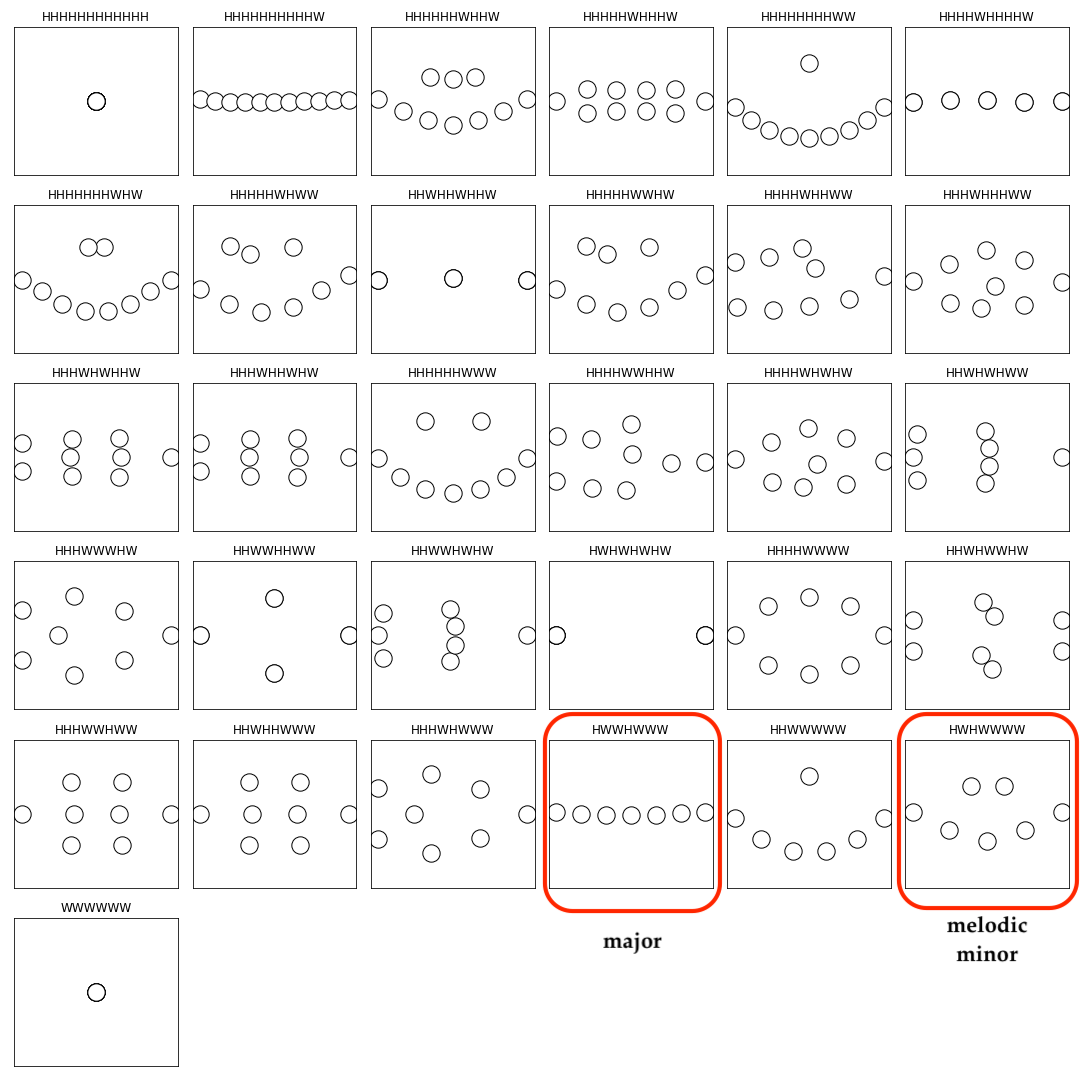

In [17]:
# fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(15, 15))

# axs = axs.flatten()

# sds = step_dist_from_total(12)

# ind = 0
# for sd in sds:
#     necklaces = get_necklaces(step_tuple_to_HW_string(sd), fast=True)
#     for pattern in necklaces:
#         base_pattern_to_MDS_manifold(pattern, axs[ind])
#         ind += 1
        
# while ind < len(axs):
#     axs[ind].set_visible(False)
#     ind += 1
    
# plt.tight_layout()

# # fig.savefig('12_half_step_mode_universe_MDS.png')
# # plt.close('all')

result_image = Image("./12_half_step_mode_universe_MDS_annotated.png")
display(result_image)

# Wrap up

One of our questions was: Is this linear structure special?

The answer is: It appears so!

Only one 12 half-step mode (other than ionian) had a linear structure - HHHHHHHHHHW.
It might be fun to play around with this mode, but it looks pretty darn chromatic.
The linearity seems somehow "too obvious" from this pattern and this makes me tempted to disregard it.

How much should we read into the geometries we see?

In part this is answered by the "stress" associated with the MDS fit.
I don't report it here, but only the linear and linear / reduced manifolds had a low stress.
A little playing around seemed to indicate that many of the other manifolds did not lower their stress significantly by embedding in a higher dimension.

It might be interesting to explore this a little by examining the "elbow" associated with the stress as a function of embedding dimension.

It might also be worthwhile looking at a few different metrics (other than Manhattan).

Regarding our other question: Is the appearance of the circle of fifths in our linear structure *obvious* or *amazing*?

I don't think I can answer that question right now..
What do you think?

In [18]:
plt.close('all')